## Стратифицированное разделение данных

### Версия Python

In [1]:
!python -V

Python 3.12.6


### Импорт необходимых библиотек

In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import glob
import qbstyles
import polars as pl
import pandas as pd
import pyarrow
import sklearn
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as tq
import jupyterlab as jlab
import multiprocessing
import shutil
import ipywidgets

from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from qbstyles import mpl_style

mpl_style(dark = False)

### Версии необходимых библиотек

In [3]:
packages = [
    "Polars", "Pandas", "Matplotlib", "Seaborn", "PyArrow", "Scikit-Learn", "Ipywidgets", "Tqdm", "JupyterLab", "Qbstyles"
]

package_objects = [
    pl, pd, matplotlib, sns, pyarrow, sklearn, ipywidgets, tq, jlab, qbstyles
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path_to_reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path_to_reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Polars""","""1.7.1"""
2,"""Pandas""","""2.2.3"""
3,"""Matplotlib""","""3.9.2"""
4,"""Seaborn""","""0.13.2"""
5,"""PyArrow""","""17.0.0"""
6,"""Scikit-Learn""","""1.5.2"""
7,"""Ipywidgets""","""8.1.5"""
8,"""Tqdm""","""4.66.5"""
9,"""JupyterLab""","""4.2.5"""


### Чтение всех файлов

In [13]:
# Получение количества ядер процессора
num_cores_cpu = multiprocessing.cpu_count()

# Определение пути к папке с CSV файлами
path_to_files = Path("/Users/dl/GitHub/ArenaVSRS/data/vacancies_subjects_association/Связка_вакансии_дисциплины_v5_сортировка/csv/paraphrase-multilingual-MiniLM-L12-v2")
path_to_files = Path("/Users/dl/GitHub/ArenaVSRS/data/vacancies_subjects_association/Связка_вакансии_дисциплины_v5_сортировка/csv/ru-en-RoSBERTa")

# Получение списка всех CSV файлов
csv_files = list(path_to_files.rglob("*.csv"))

# Функция для чтения CSV файлов
def load_csv(file_path):
    return pl.read_csv(file_path, encoding = "utf-8-sig", separator = ';', n_threads = num_cores_cpu)

# Ограничение количества потоков
max_workers = min(num_cores_cpu, len(csv_files))

# Чтение файлов параллельно с использованием ThreadPoolExecutor
with ThreadPoolExecutor(max_workers = max_workers) as executor:
    results = list(tqdm(executor.map(load_csv, csv_files), desc = "Обработка CSV файлов", total = len(csv_files), unit = "файл"))

# Объединение всех файлов в один DataFrame
df_vsa = pl.concat(results)

Обработка CSV файлов: 100%|█████████████████████████████████████████████████████████| 117/117 [00:21<00:00,  5.48файл/s]


In [14]:
print(f"Всего строк: {len(df_vsa)}")

Всего строк: 282866


### Удаление строк с пустыми значениями

In [15]:
# Удаление строк с пустыми значениями в указанных колонках
df_vsa_clean = df_vsa.drop_nulls(subset = ["Name", "ProfessionalRoles", "Skills", "SBERT_plus_LLM_Recommendations"])

print(f"Всего строк после чистки: {df_vsa_clean.height}")

Всего строк после чистки: 279531


### Фильтрация строк (исключение специализаций)

In [16]:
# Подсчет количества вхождений для каждого значения в специализации
role_counts = df_vsa_clean.group_by("ProfessionalRoles").agg(pl.col("ProfessionalRoles").len().alias("count"))

# Фильтрация для оставления только тех специализаций, в которых количество записей >= 10
roles_to_keep = role_counts.filter(pl.col("count") >= 10)["ProfessionalRoles"]

# Фильтрация DataFrame для оставления только нужных специализаций
df_vsa_clean_filtered = df_vsa_clean.filter(pl.col("ProfessionalRoles").is_in(roles_to_keep))

print(f"Всего строк после фильтрации: {df_vsa_clean_filtered.height}")

Всего строк после фильтрации: 279477


### Общая статистика

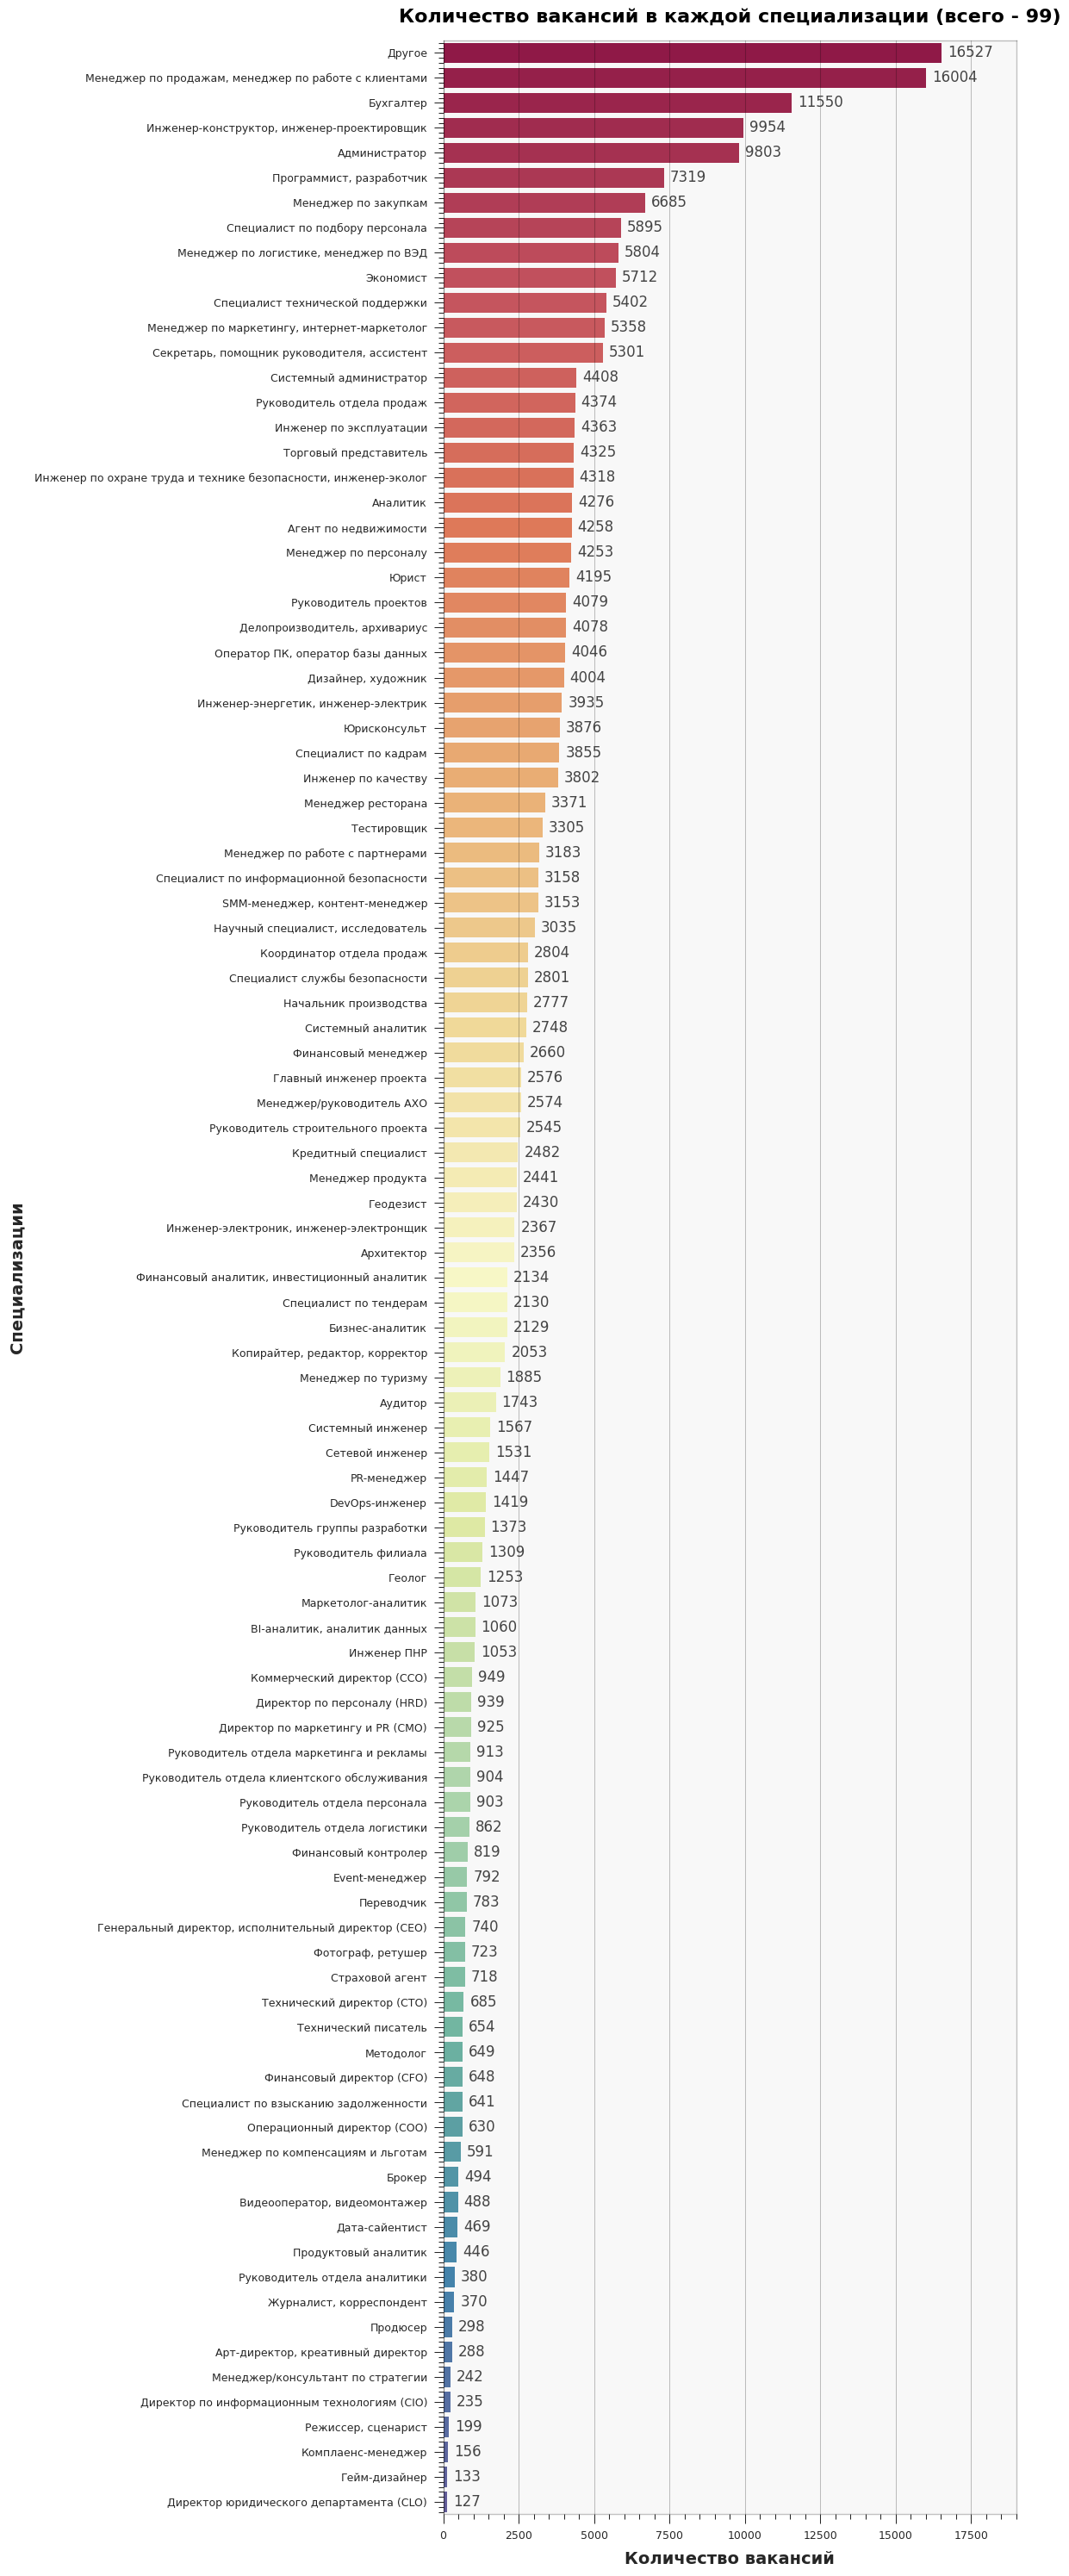

In [17]:
# Определение нужного столбца
column = "ProfessionalRoles"

# Подсчет количества уникальных значений
value_counts = df_vsa_clean_filtered.group_by(column).agg(pl.len())

# Создание нового DataFrame для визуализации и сортировка по убыванию
sorted_df = value_counts.sql("SELECT ProfessionalRoles, len FROM self ORDER BY len DESC")

# Визуализация
plt.figure(figsize = (12, 30))
ax = sns.barplot(y = sorted_df[column], x = sorted_df["len"], palette = "Spectral")

# Определение максимального значения для оси X и добавление буфера
max_value = sorted_df["len"].max()
buffer = max_value * 0.15

# Установка диапазона оси X
ax.set_xlim(0, max_value + buffer)

# Добавление чисел справа от каждого столбца
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = "left", va = "center", xytext = (5, 0), textcoords = "offset points", fontsize = 12, color = "#444")

# Настройка заголовка и подписей
plt.title(f"Количество вакансий в каждой специализации (всего - {value_counts.height})", fontsize = 16, fontweight = "bold")
plt.xlabel("Количество вакансий", fontsize = 14, fontweight = "bold")
plt.ylabel("Специализации", fontsize = 14, fontweight = "bold")

# Уменьшение отступов и улучшение размещения
plt.tight_layout()

# Отображение графика
plt.show()

### Стратифицированное разделение данных на обучающую, валидационную и тестовую выборки

In [18]:
# Параметры для разделения данных
TRAIN_SIZE = 0.7
VAL_SIZE = 0.1
TEST_SIZE = 0.2
RANDOM_STATE = 10091991

# Путь для сохранения
SAVE_PATH = Path("/Users/dl/GitHub/ArenaVSRS/data/vacancies_subjects_association/Связка_вакансии_дисциплины_v5_сортировка/parquet/paraphrase-multilingual-MiniLM-L12-v2")
SAVE_PATH = Path("/Users/dl/GitHub/ArenaVSRS/data/vacancies_subjects_association/Связка_вакансии_дисциплины_v5_сортировка/parquet/ru-en-RoSBERTa")

# Проверка и создание/очистка целевой папки
def prepare_save_path(save_path):
    if save_path.exists():
        shutil.rmtree(save_path)
    save_path.mkdir(parents = True, exist_ok = True)

prepare_save_path(SAVE_PATH)

# Функция для стратифицированного разделения данных
def stratified_split(df, stratify_col, train_size, val_size, test_size, random_state):
    # StratifiedShuffleSplit для разделения на train и temp (val + test)
    stratified_splitter = StratifiedShuffleSplit(
        n_splits = 1, 
        test_size = (val_size + test_size), 
        train_size = train_size, 
        random_state = random_state
    )
    
    # Процесс разделения train и temp выборок
    tqdm_iter = tqdm(stratified_splitter.split(
        df.to_pandas(), df[stratify_col].to_pandas()), desc = "Разделение train/temp", total = 1, unit = "dataframe"
    )

    for train_index, temp_index in tqdm_iter:
        train_data = df[train_index]
        temp_data = df[temp_index]

    # StratifiedShuffleSplit для разделения временной выборки на val и test
    temp_splitter = StratifiedShuffleSplit(
        n_splits = 1, 
        test_size = test_size / (test_size + val_size), 
        random_state = random_state
    )
    
    # Процесс разделения temp выборки на val и test
    tqdm_iter = tqdm(temp_splitter.split(
        temp_data.to_pandas(), temp_data[stratify_col].to_pandas()), desc = "Разделение val/test", total = 1, unit = "dataframe"
    )

    for val_index, test_index in tqdm_iter:
        val_data = temp_data[val_index]
        test_data = temp_data[test_index]
    
    return train_data, val_data, test_data

# Функция для преобразования данных в формат instruction-input-output
def convert_to_instruction_format_with_progress(df, instruction_text, name_col, role_col, skill_col, recommendation_col):
    formatted_rows = []

    for row in tqdm(df.iter_rows(named = True), desc = "Преобразование данных в нужный формат", total = df.shape[0], unit = "строка"):
        instruction = instruction_text
        input_text = f"Название: {row[name_col]}. Роли: {row[role_col]}. Навыки: {row[skill_col]}"
        output_text = row[recommendation_col]
        formatted_rows.append((instruction, input_text, output_text))

    formatted_df = pl.DataFrame(
        formatted_rows, 
        schema = ["instruction", "input", "output"],
        orient = "row" # Явное указывание, что данные ориентированы по строкам
    )
    
    return formatted_df

# Параметры для преобразования данных
INSTRUCTION_TEXT = "Какие дисциплины можно порекомендовать для данной вакансии?"
NAME_COL = "Name"
ROLE_COL = "ProfessionalRoles"
SKILL_COL = "Skills"
RECOMMENDATION_COL = "SBERT_plus_LLM_Recommendations"

train_dataset, val_dataset, test_dataset = stratified_split(
    df_vsa_clean_filtered, 
    stratify_col = "ProfessionalRoles", 
    train_size = TRAIN_SIZE, 
    val_size = VAL_SIZE, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

train_dataset_formatted = convert_to_instruction_format_with_progress(
    train_dataset, 
    INSTRUCTION_TEXT, 
    NAME_COL, 
    ROLE_COL, 
    SKILL_COL, 
    RECOMMENDATION_COL
)

val_dataset_formatted = convert_to_instruction_format_with_progress(
    val_dataset, 
    INSTRUCTION_TEXT, 
    NAME_COL, 
    ROLE_COL, 
    SKILL_COL, 
    RECOMMENDATION_COL
)

test_dataset_formatted = convert_to_instruction_format_with_progress(
    test_dataset, 
    INSTRUCTION_TEXT, 
    NAME_COL, 
    ROLE_COL, 
    SKILL_COL, 
    RECOMMENDATION_COL
)

# Функция для сохранения DataFrame в Parquet
def save_to_parquet(df, file_path):
    df.write_parquet(file_path)

# Сохранение выборок
save_to_parquet(train_dataset_formatted, SAVE_PATH / "train_dataset.parquet")
save_to_parquet(val_dataset_formatted, SAVE_PATH / "val_dataset.parquet")
save_to_parquet(test_dataset_formatted, SAVE_PATH / "test_dataset.parquet")

# Проверка размеров выборок
print(f"Обучающая выборка: {train_dataset_formatted.shape[0]} записей")
print(f"Валидационная выборка: {val_dataset_formatted.shape[0]} записей")
print(f"Тестовая выборка: {test_dataset_formatted.shape[0]} записей")

Преобразование данных в нужный формат: 100%|███████████████████████████████| 55896/55896 [00:01<00:00, 28743.67строка/s]


Обучающая выборка: 195633 записей
Валидационная выборка: 27948 записей
Тестовая выборка: 55896 записей


### Тестирование Parquet файлов

In [19]:
# Получение количества ядер процессора
num_cores_cpu = multiprocessing.cpu_count()

# Определение пути к папке с Parquet файлами
path_to_files = Path("/Users/dl/GitHub/ArenaVSRS/data/vacancies_subjects_association/Связка_вакансии_дисциплины_v5_сортировка/parquet/paraphrase-multilingual-MiniLM-L12-v2")
path_to_files = Path("/Users/dl/GitHub/ArenaVSRS/data/vacancies_subjects_association/Связка_вакансии_дисциплины_v5_сортировка/parquet/ru-en-RoSBERTa")

# Получение списка всех Parquet файлов (train, val, test)
parquet_files_train = list(path_to_files.rglob("*train*.parquet"))
parquet_files_val = list(path_to_files.rglob("*val*.parquet"))
parquet_files_test = list(path_to_files.rglob("*test*.parquet"))

# Функция для чтения Parquet файлов
def load_parquet(file_path):
    return pl.read_parquet(file_path)

# Ограничение количества потоков
max_workers = min(num_cores_cpu, len(parquet_files_train + parquet_files_val + parquet_files_test))

# Чтение train файлов
with ThreadPoolExecutor(max_workers = max_workers) as executor:
    train_dfs = list(tqdm(executor.map(
        load_parquet, parquet_files_train), desc = "Обработка train файлов", total = len(parquet_files_train), unit = "файл")
    )

# Чтение val файлов
with ThreadPoolExecutor(max_workers = max_workers) as executor:
    val_dfs = list(tqdm(executor.map(
        load_parquet, parquet_files_val), desc = "Обработка val файлов", total = len(parquet_files_val), unit = "файл")
    )

# Чтение test файлов
with ThreadPoolExecutor(max_workers = max_workers) as executor:
    test_dfs = list(tqdm(executor.map(
        load_parquet, parquet_files_test), desc = "Обработка test файлов", total = len(parquet_files_test), unit = "файл")
    )

# Объединение всех файлов в один DataFrame для каждой выборки
train_dataset = pl.concat(train_dfs)
val_dataset = pl.concat(val_dfs)
test_dataset = pl.concat(test_dfs)

# Проверка размеров выборок
print(f"Обучающая выборка: {train_dataset_formatted.shape[0]} записей")
print(f"Валидационная выборка: {val_dataset_formatted.shape[0]} записей")
print(f"Тестовая выборка: {test_dataset_formatted.shape[0]} записей")

Обработка test файлов: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.32файл/s]

Обучающая выборка: 195633 записей
Валидационная выборка: 27948 записей
Тестовая выборка: 55896 записей


### Статистика разделеных данных

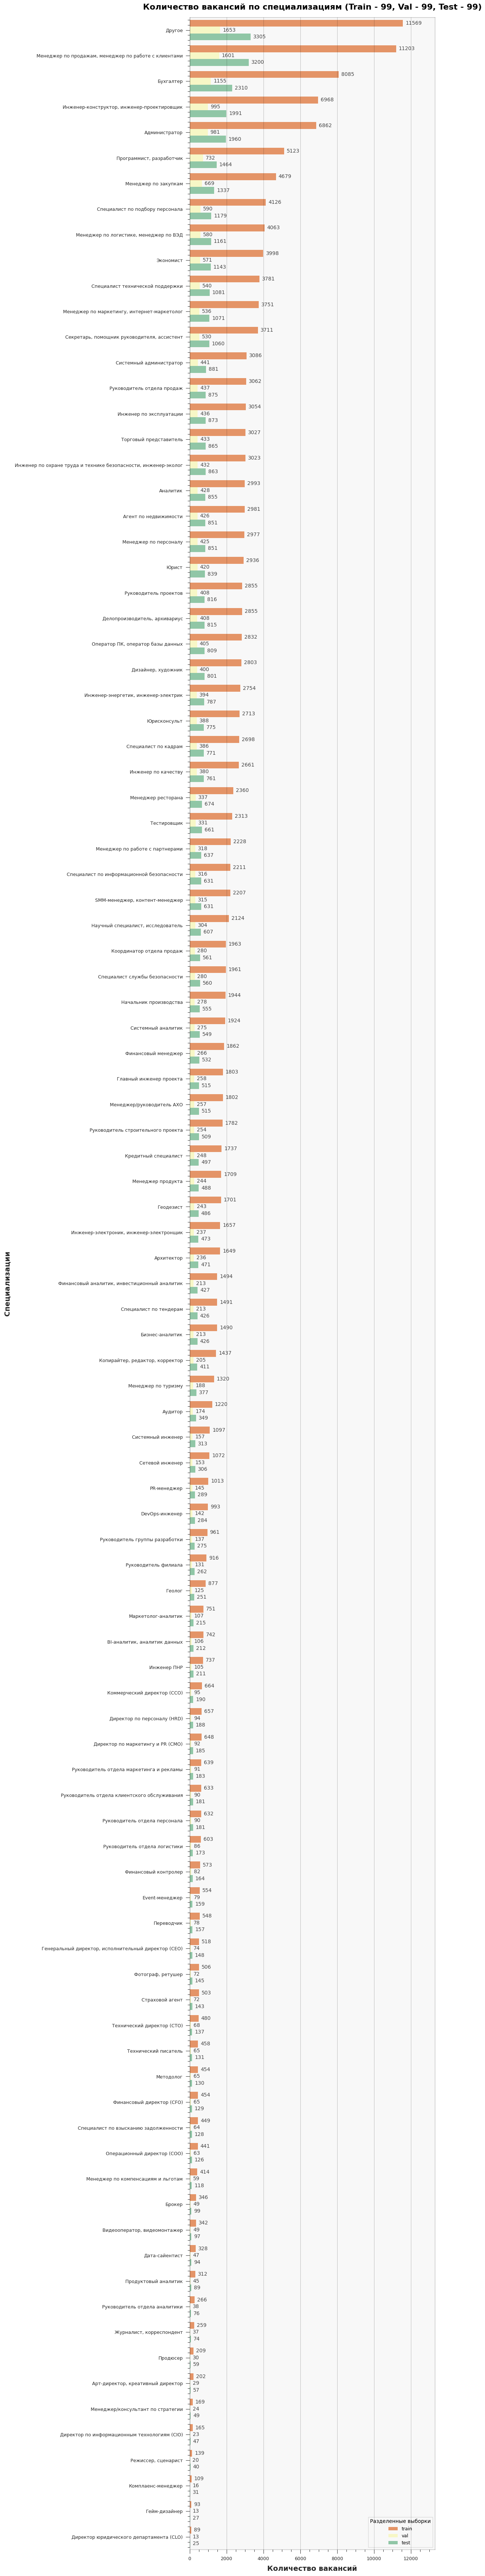

In [20]:
# Функция для извлечения значений "Роли" из строки input
def extract_roles(df):
    return df.with_columns(
        pl.col("input")
        .str.extract(r"Роли: ([^\.]+)")
        .alias("roles")
    )

# Применение функции к train, val и test выборкам
train_dataset = extract_roles(train_dataset)
val_dataset = extract_roles(val_dataset)
test_dataset = extract_roles(test_dataset)

# Подсчет количества уникальных специализаций в каждой выборке
train_value_counts = train_dataset.group_by("roles").agg(pl.len().alias("train"))
val_value_counts = val_dataset.group_by("roles").agg(pl.len().alias("val"))
test_value_counts = test_dataset.group_by("roles").agg(pl.len().alias("test"))

# Объединение результатов в один DataFrame для визуализации
combined_df = train_value_counts.join(val_value_counts, on = "roles", how = "full", suffix = "_val") \
                                .join(test_value_counts, on = "roles", how = "full", suffix = "_test")

# Сортировка по количеству в train в порядке убывания
combined_df = combined_df.sort("train", descending = True)

# Преобразование в pandas для визуализации через seaborn
combined_df_pd = combined_df.to_pandas()

# Преобразование таблицы
melted_df = pd.melt(
    combined_df_pd,
    id_vars = ["roles"],
    value_vars = ["train", "val", "test"], 
    var_name = "Разделенные выборки",
    value_name = "Специализации"
)

# Подсчет уникальных специализаций
num_train_roles = train_dataset["roles"].n_unique()
num_val_roles = val_dataset["roles"].n_unique()
num_test_roles = test_dataset["roles"].n_unique()

# Форматирование заголовка
title = (f"Количество вакансий по специализациям (Train - {num_train_roles}, "
         f"Val - {num_val_roles}, Test - {num_test_roles})")

# Визуализация
plt.figure(figsize = (12, 70))
ax = sns.barplot(y = melted_df["roles"], x = melted_df["Специализации"], hue = melted_df["Разделенные выборки"], palette = "Spectral")

# Определение максимального значения для оси X и добавление буфера
max_value = melted_df["Специализации"].max()
buffer = max_value * 0.15

# Установка диапазона оси X
ax.set_xlim(0, max_value + buffer)

# Добавление чисел справа от каждого столбца только если ширина больше 0
for p in ax.patches:
    width = p.get_width()
    if width > 0:  # Проверка на ширину
        ax.annotate(f"{int(width)}", (width, p.get_y() + p.get_height() / 2.),
                    ha = "left", va = "center", xytext = (5, 0), textcoords = "offset points", fontsize = 10, color = "#444")

# Настройка заголовка и подписей
plt.title(title, fontsize = 16, fontweight = "bold")
plt.xlabel("Количество вакансий", fontsize = 14, fontweight = "bold")
plt.ylabel("Специализации", fontsize = 14, fontweight = "bold")

# Уменьшение отступов и улучшение размещения
plt.tight_layout()

# Отображение графика
plt.show()

### Пример значений

In [21]:
print(f"instruction: {train_dataset_formatted[0]["instruction"][0]}")
print(f"\ninput: {train_dataset_formatted[0]["input"][0]}")
print(f"\noutput: {train_dataset_formatted[0]["output"][0]}")
train_dataset_formatted[0]

instruction: Какие дисциплины можно порекомендовать для данной вакансии?

input: Название: Менеджер по логистике на спецтранспорт (Диспетчер). Роли: Менеджер по логистике, менеджер по ВЭД. Навыки: Транспортная логистика, Логистика, Телефонные переговоры, Автомобильные перевозки, Автомобильные грузоперевозки, Экспедирование, Внутрироссийские грузоперевозки, Логистический менеджмент, Деловое общение, Деловая переписка

output: Мировая и российская логистика; Транспортная логистика; Логистика и управление цепями поставок; Логистика и управление цепями поставок в ритейле; Основы логистики; Управленческая отчетность; Поиск и привлечение клиентов; Телефонные переговоры; Управленческая отчетность; Поиск и привлечение клиентов; Телефонные переговоры


instruction,input,output
str,str,str
"""Какие дисциплины можно пореком…","""Название: Менеджер по логистик…","""Мировая и российская логистика…"
